# AB - тестирование

# Задание
   Эксперимент проходил с 2022-09-03 по 2022-09-09 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов (рекомендация постов, похожих на лайкнутые прежде), группа 1 использовалась в качестве контроля. 
   Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
Наша задача — проанализировать данные АB-теста. 

### Загрузим необходимые библиотеки. Выгрузим из нашей базы необходимые данные: юзеров 1 и 2 группы, их просмотры, лайки, а также значение CTR.

In [1]:
import pandahouse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib 
from scipy import stats # статистика
%matplotlib inline
sns.set()

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220920'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-03' and '2022-09-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df.head(5)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


### Проверим количество юзеров в наших группах.

In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Как видим, количество юзеров в наших группах примерно одинаковое.

### Построим гистограммы распределения средних значений CTR в наших группах.

<AxesSubplot:xlabel='ctr', ylabel='Count'>

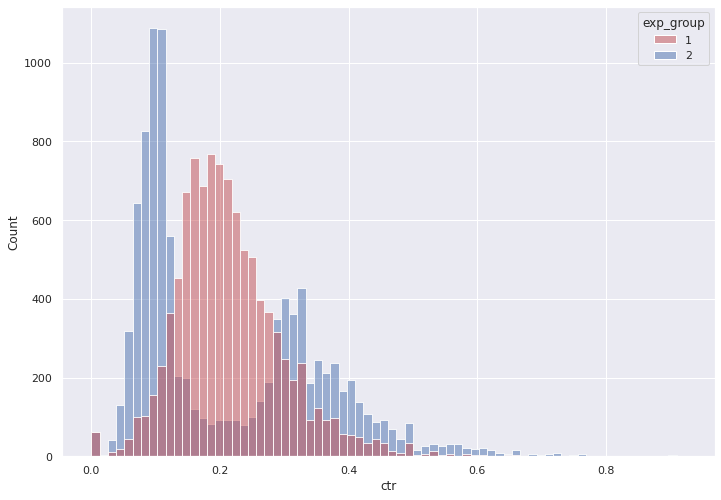

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

  **На гистограмме мы замечаем интересную ситуацию. Распределение первой, контрольной группы, близко к нормальному, с небольшим скосом в левую сторону. В это же время, распределение второй группы, на которой опробывался новый механизм рекомендаций, двугорбое или бимодальное. Это говорит о том, что наша группа перестала быть однородной после использования на ней новых рекомендаций. При этом горбы нашего распределения асиметричны, юзеров с небольшими средними значениями CTR больше, чем с высокими. Наша группа поляризовалась по сравнению с первой, можно предположить, что одной части пользователей пришёлся по душе новый алгоритм рекомендаций, в то время как вторая часть не приняла нововведений.
  Бимодальность нашего распределения необходимо учитывать при проведении статистических тестов и быть аккуратными при их интерпретации.**
    

### Определим среднее и медианное значения нашего CTR

In [6]:
df.groupby('exp_group').agg({'ctr':'mean'})


,ctr
exp_group,
1,0.215605
2,0.214419


In [7]:
df.groupby('exp_group').agg({'ctr':'median'})

,ctr
exp_group,
1,0.203125
2,0.142857


**Как мы видим, средние значения наших групп практически равны, в то время как медианное значение отличается на треть.**

## T-test

In [8]:
t_test = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)[1]
print('p-value =',t_test)
if t_test < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")


p-value = 0.4780623130874935
Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.


**Результат проведенного t-теста показал, что статистически значимая разница между нашими группами отсутствует. Однако мы не можем считать результаты t-теста корректными, так как наше распределение не является нормальным. Оно бимодальное, с большим левым горбом и наличием хвоста в правой части.**

## Тест Манна-Уитни

In [9]:
t_testmw = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                alternative='two-sided')[1]
print('p-value = {}'.format(t_testmw))
if t_testmw < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 6.0376484617779035e-56
Разница между средними значениями CTR групп 1 и 2 статистически значимая.


In [10]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 55.63 % случаев A > B. Должно получиться около 50%


**Тест Манна-Уитни не так привязан к нормальности распределения. Результаты теста показывают наличие статистически значимой разницы между группами. Однако, количество случаев, когда при попарном сравнении значений между группами, значение в одной из групп больше, составляет 56,37%, хоть должно быть ближе к 50%. Для большей достоверности попробуем другие методы сравнения наших групп.**

## Сглаженный CTR

In [11]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()




<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

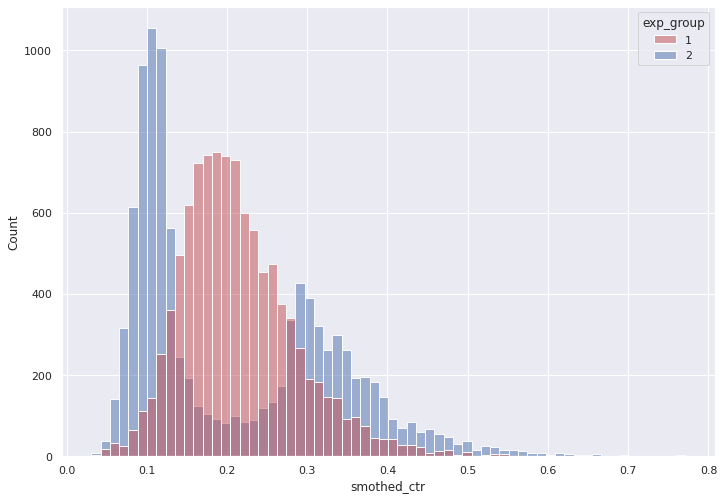

In [12]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(data=pd.concat([group1,group2]),
                     x = 'smothed_ctr',
                     hue='exp_group',
                     palette = ['r', 'b'],
                     alpha = 0.5,
                     kde=False)

### Проведем t-тест на сглаженном CTR.

In [13]:
t_testsm = stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)[1]
print('p-value =',t_testsm)
if t_testsm < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 0.0223769815558559
Разница между средними значениями CTR групп 1 и 2 статистически значимая.


## Тест Манна-Уитни на сглаженном CTR

In [14]:
t_testmwsm = stats.mannwhitneyu(group1.smothed_ctr,
                group2.smothed_ctr,
                alternative='two-sided')[1]
print('p-value = {}'.format(t_testmwsm))
if t_testmwsm < 0.05:
    print("Разница между средними значениями CTR групп 1 и 2 статистически значимая.")
else:     
    print("Между средними значениями CTR групп 1 и 2 отстутствует статистически значимая разница.")

p-value = 1.6163964114270227e-61
Разница между средними значениями CTR групп 1 и 2 статистически значимая.


**В результате проведения t-теста и теста Манна-Уитни на сглаженном CTR, оба теста показали наличие статистически значимой разницы между нашими группами. Можно предположить, что при использовании сглаженного CTR мы уменьшили количество выбросов в нашем распределении, а также свели к минимуму 
вероятность больших по модулю отклонений, что сделало работу t-теста более корректной.**

## Пуассоновский бутстреп

<AxesSubplot:ylabel='Count'>

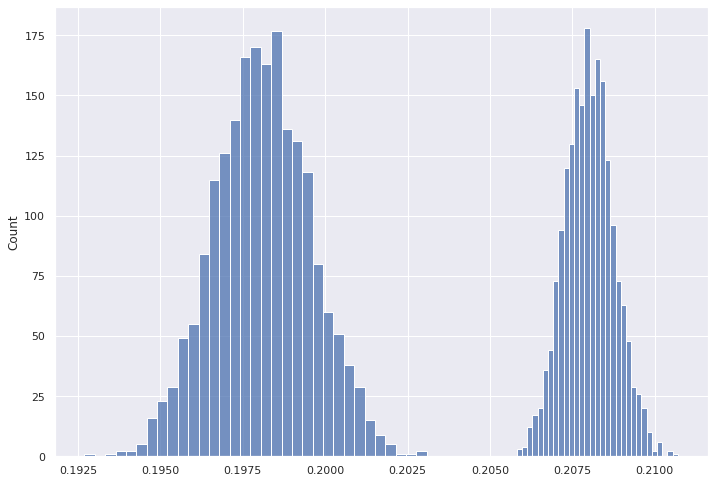

In [15]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

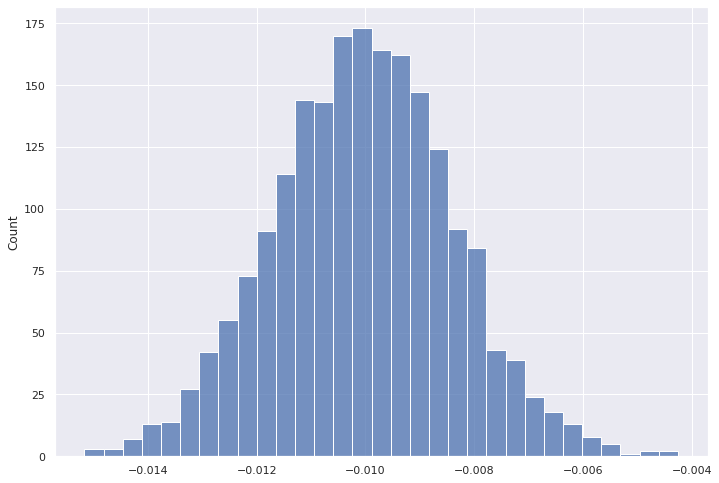

In [13]:
sns.histplot(ctr2 - ctr1)

**Благодоря использованию Пуассоновского бутстрепа, мы можем сделать ряд выводов. Мы можем утверждать, что в группе 1 значения глобального CTR выше, чем в группе 2. Гистограммы распределений глобального CTR не пересекаются, если мы проведем t-тест, значение p-value будет равно 0. При построении гистограммы разниц глобальных CTR, отняв значения группы 2 от значений группы 1, можно наблюдать, что значения наших разниц - отрицательные. А данные результаты абсолютно противоположны нашей гипотезе. При использовании новой методики рекомендаций, значения CTR стали ниже, чем при традиционной подаче ленты новостей.**

## Бакетное преобразование

Разобъём наших пользователей на n «корзинок» («бакетов»). При этом, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно.

In [16]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)



In [17]:
df.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


#### Проведём t-тест и тест Манна-Уитни поверх бакетного преобразования.

Тест Манна-Уитни

In [22]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

T-тест

In [23]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)


Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Оба теста показали наличие статистической разности между нашими группами.

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

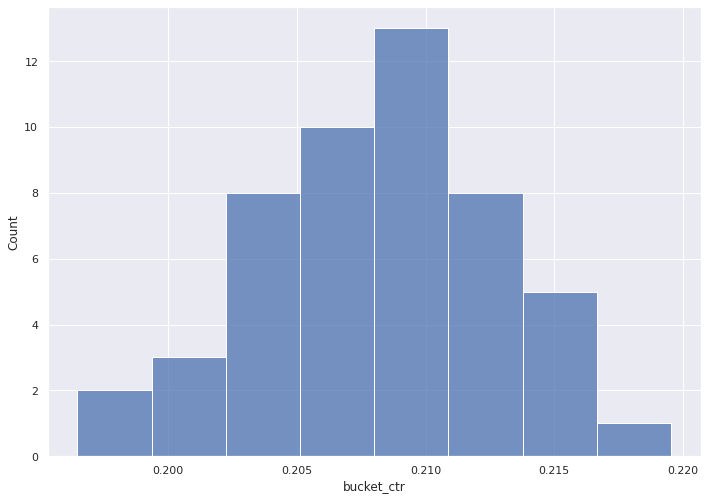

In [24]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

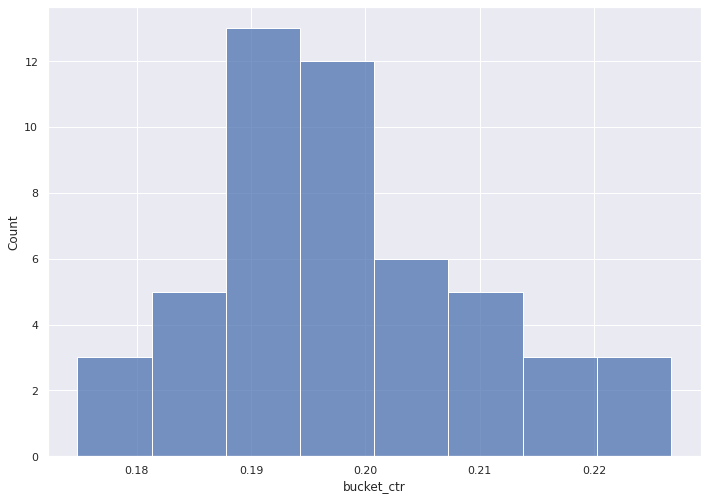

In [25]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

Гистограммы распределения CTR после бакетного преобразования показывают, что распределение CTR в группе 1 близко к нормальному, а вот в группе 2 наблюдается асимметрия со смещением влево и удлиненным хвостом вправо.

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

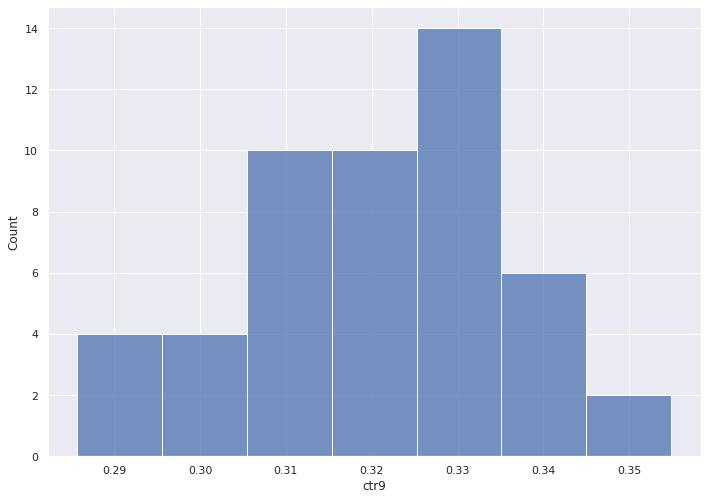

In [27]:
sns.histplot(df[df.exp_group == 1].ctr9)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

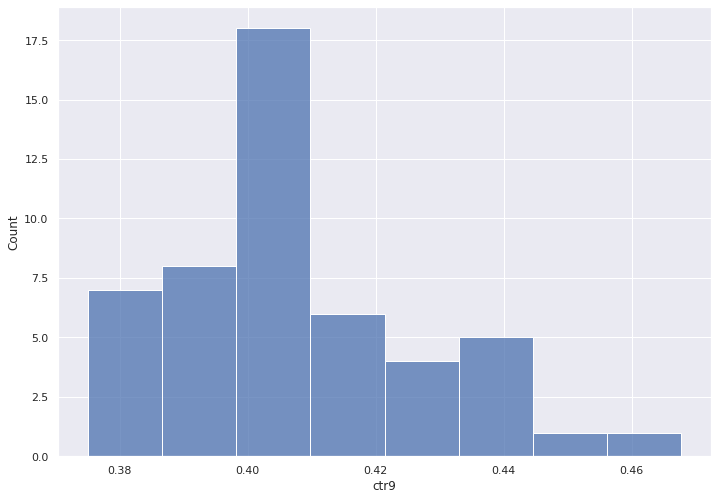

In [28]:
sns.histplot(df[df.exp_group == 2].ctr9)

Анализ распределения 90% процентиля также указывает на то, что во второй группе присутствует большой разброс показателей, распределение смещено влево, присудствует удлиненный хвост вправо.

## Вывод

   **Нами было произведено сравнение двух групп, тестовой и контрольной, для подтверждения гипотезы о том, что после изменения алгоритма рекомендаций ленты новостей, значение CTR станет выше. Для этого мы использовали t-тест, тест Манна-Уитни, тесты поверх сглаженного CTR и бакетного преобразования, а также Пуассоновский бутстреп. Отметим, что распределение среднего CTR во второй группе неравномерное, бимодальное с наличием выбросов, поэтому применение t-теста в нашем исследовании нежелательно. Что и было подтверждено нами. Результаты t-теста показали отсутствие различия между выборками. Лучше отдать предпочтение тесту Манна-Уитни, не так зависящего от характера распределения. 
   В результате применения сглаженного CTR, оба теста показали одинаковые результаты о наличии статистически значимой разницы между группами. Сглаживание CTR помогло устранить выбросы в нашем распределении, что сделало работу т-теста более корректной, однако неравномерность распределения сохранилось, поэтому нужно быть осторожными при трактовке результата теста.
   Пуассоновский бутстреп и тесты поверх бакетного преобразования также показали наличие разницы между нашими группами.
Однако, результаты нашего эксперимента не подтверждают выдвинутую гипотезу. В результате использования нового алгоритма рекомендаций, значение CTR не увеличилось. Поэтому на данном этапе не рукомендуется распространять данный алгоритм на всех пользователей. При этом, исходя из гистограммы распределения CTR тестовой группы, можно утверждать, что пользователией можно разделить на две группы - тех, кто принял новый алгоритм позитивно (правый горб нашего распределения с высокими CTR) и тех, кому нововведения пришлись не по душе (левый горб с низкими CTR по сравнению с контрольной группой). Логичным видится проведение исследования с целью выявления причин разницы между группами (по количеству просмотров, гендеру, возрасту и т.д.). При выявлении причин, алгоритм рекомендаций можно даработать и снова попробовать протестировать на пользователях. Возможной причиной опровержения гипотезы может быть также изначально плохо разработанный алгоритм рекомендаций.**